In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import datasets, layers, models
import matplotlib.pyplot as plt
import numpy as np

# Data description
- The data is collected from benchmark, simulated malware and simulated stress application
- 12 metrics are listed as below:
 
 - 0) cpu_system
 - 1) cpu_idle
 - 2) cpu_user
 - 3) cpu_iowait
 - 4) pod_count
 - 5) system_load
 - 6) mem_total
 - 7) mem_avail
 - 8) disk_io
 - 9) disk_space_used
 - 10) net_received
 - 11) net_transmit

In [ ]:
#!rm -rf CBT
!git clone https://github.com/levanthanh3005/CBT

Cloning into 'CBT'...
remote: Enumerating objects: 121, done.
remote: Counting objects: 100% (121/121), done.
remote: Compressing objects: 100% (110/110), done.
remote: Total 121 (delta 16), reused 116 (delta 11), pack-reused 0
Receiving objects: 100% (121/121), 2.71 MiB | 6.29 MiB/s, done.
Resolving deltas: 100% (16/16), done.


In [ ]:
from os import listdir
from os.path import isfile, join

def breakData(dataTrain, dataLabel, breakPoint):
    totalTime = dataTrain.shape[2]
    lsTrain = []
    lsLabel = []
    bCount = int(totalTime / breakPoint)
#     print("bCount:",bCount)
    for e in range(bCount):
#         print("from:",breakPoint*e," to:",breakPoint*(e+1))
        lsTrain.append(dataTrain[:,:,breakPoint*e:breakPoint*(e+1)][0])
        lsLabel.append(dataLabel[0][0])
    if totalTime % breakPoint > 0:
#         print("from:",(totalTime-breakPoint)," to:",totalTime)
        lsTrain.append(dataTrain[:,:,(totalTime-breakPoint):totalTime][0])
        lsLabel.append(dataLabel[0][0])

#     print("breakdata:",np.array(lsTrain).shape)
    return lsTrain,lsLabel
def viewAllDataFromFolder(dataPath,lablePath,breakPoint):
    onlyfiles = [f for f in listdir(dataPath) if isfile(join(dataPath, f))]
    count = 0
    fileLs = []
    lsBdTrain = None
    lsBdLabel = None
    for fs in onlyfiles:
#         print(fs)
        count = count + 1
        with open(lablePath+"/"+fs, 'rb') as f:
            dataLabel = np.load(f)
        with open(dataPath+"/"+fs, 'rb') as f:
            dataTrain = np.load(f)
#         print("dataTrain.shape:",dataTrain.shape,"  dataLabel.shape:",dataLabel.shape," label value:",dataLabel[0])
#         print(dataTrain[:,:,:121].shape)
        bdTrain,bdLabel = breakData(dataTrain,dataLabel, breakPoint)
        if count == 1:
            lsBdTrain = np.array(bdTrain)
            lsBdLabel = np.array(bdLabel)
        else:
            lsBdTrain = np.append(lsBdTrain,bdTrain,axis=0)
            lsBdLabel = np.append(lsBdLabel,bdLabel,axis=0)
    unique, counts = np.unique(lsBdLabel, return_counts=True)
    print("Num of file:",len(onlyfiles))
    print("Label:",dict(zip(unique, counts)))
    lsBdLabel = lsBdLabel.reshape((lsBdLabel.shape[0],1))
    
    print("Shape lsBdTrain:",lsBdTrain.shape," lsBdLabel:",lsBdLabel.shape)
    return lsBdTrain,lsBdLabel

# Run with all metrics

In [ ]:
trainData,labelData = viewAllDataFromFolder("CBT/data","CBT/label",121)

Num of file: 20
Label: {0: 46, 1: 48}
Shape lsBdTrain: (94, 12, 121)  lsBdLabel: (94, 1)


In [ ]:
model = keras.Sequential()
model.add(keras.layers.LSTM(80, input_shape=[trainData.shape[1], trainData.shape[2]]))
# model.add(keras.layers.Bidirectional(keras.layers.LSTM(200,return_sequences=True), input_shape=[trainData.shape[1], trainData.shape[2]]))
# model.add(keras.layers.Dense(500))
# model.add(keras.layers.Dense(200))
# model.add(keras.layers.Dense(50))
# model.add(keras.layers.Dense(labelData.shape[1], activation='softmax'))
# model.add(keras.layers.Flatten())
model.add(keras.layers.Dense(labelData.shape[1], activation='sigmoid' ))

# model.compile(loss='mae', optimizer='adam', metrics=['accuracy'])
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 80)                64640     
_________________________________________________________________
dense (Dense)                (None, 1)                 81        
Total params: 64,721
Trainable params: 64,721
Non-trainable params: 0
_________________________________________________________________


In [ ]:
history = model.fit(
    trainData, labelData,
    epochs=500,
    batch_size=60,
    validation_split=0.2,
    shuffle=True
)

Epoch 1/500
2/2 [==============================] - 2s 481ms/step - loss: 0.6811 - accuracy: 0.5600 - val_loss: 0.7496 - val_accuracy: 0.5263
Epoch 2/500
2/2 [==============================] - 0s 36ms/step - loss: 0.6375 - accuracy: 0.6267 - val_loss: 0.8156 - val_accuracy: 0.4211
Epoch 3/500
2/2 [==============================] - 0s 30ms/step - loss: 0.6460 - accuracy: 0.6133 - val_loss: 0.8101 - val_accuracy: 0.3158
Epoch 4/500
2/2 [==============================] - 0s 33ms/step - loss: 0.6296 - accuracy: 0.6133 - val_loss: 0.7445 - val_accuracy: 0.5263
Epoch 5/500
2/2 [==============================] - 0s 30ms/step - loss: 0.6047 - accuracy: 0.6800 - val_loss: 0.6699 - val_accuracy: 0.5789
Epoch 6/500
2/2 [==============================] - 0s 32ms/step - loss: 0.5758 - accuracy: 0.7467 - val_loss: 0.6876 - val_accuracy: 0.6316
Epoch 7/500
2/2 [==============================] - 0s 29ms/step - loss: 0.5769 - accuracy: 0.7200 - val_loss: 0.7769 - val_accuracy: 0.3684
Epoch 8/500
2/2 [==

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


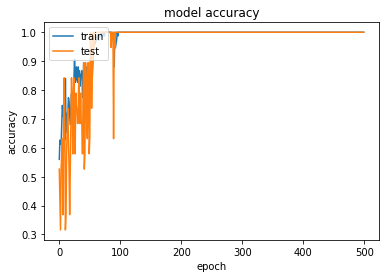

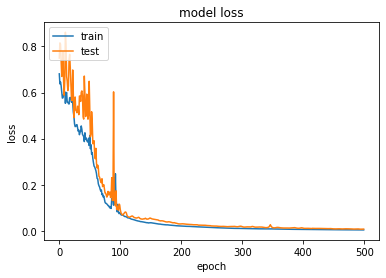

In [ ]:
# list all data in history
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:
model.save('cbt.h5')

# testing 1: LSTM with 5 metrics

In [ ]:
trainData,labelData = viewAllDataFromFolder("CBT/data","CBT/label",121)

Num of file: 20
Label: {0: 46, 1: 48}
Shape lsBdTrain: (94, 12, 121)  lsBdLabel: (94, 1)


Since we dont want to use too many features, it makes easier to be overfitting, so we only reduce to 5 features only

In [ ]:
trainData = np.delete(trainData, [1,2,3,6,9,10,11], 1) # cpu_system,pod_count,system_load,mem_avail,disk_io
trainData.shape

(94, 5, 121)

In [ ]:
model = keras.Sequential()
model.add(keras.layers.LSTM(260, input_shape=[trainData.shape[1], trainData.shape[2]]))
# model.add(keras.layers.Bidirectional(keras.layers.LSTM(200,return_sequences=True), input_shape=[trainData.shape[1], trainData.shape[2]]))
# model.add(keras.layers.Dense(500))
# model.add(keras.layers.Dense(200))
model.add(keras.layers.Dense(150))
model.add(keras.layers.Dense(50))
# model.add(keras.layers.Dense(labelData.shape[1], activation='softmax'))
# model.add(keras.layers.Flatten())
model.add(keras.layers.Dense(labelData.shape[1], activation='sigmoid' ))

# model.compile(loss='mae', optimizer='adam', metrics=['accuracy'])
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 260)               397280    
_________________________________________________________________
dense_1 (Dense)              (None, 150)               39150     
_________________________________________________________________
dense_2 (Dense)              (None, 50)                7550      
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 51        
Total params: 444,031
Trainable params: 444,031
Non-trainable params: 0
_________________________________________________________________


In [ ]:
history = model.fit(
    trainData, labelData,
    epochs=500,
    batch_size=30,
    validation_split=0.2,
    shuffle=True
)

Epoch 1/500
3/3 [==============================] - 2s 241ms/step - loss: 0.8656 - accuracy: 0.5867 - val_loss: 0.3488 - val_accuracy: 1.0000
Epoch 2/500
3/3 [==============================] - 0s 31ms/step - loss: 0.7398 - accuracy: 0.5467 - val_loss: 0.6334 - val_accuracy: 0.4737
Epoch 3/500
3/3 [==============================] - 0s 28ms/step - loss: 0.6243 - accuracy: 0.6267 - val_loss: 0.8709 - val_accuracy: 0.1579
Epoch 4/500
3/3 [==============================] - 0s 35ms/step - loss: 0.5503 - accuracy: 0.6267 - val_loss: 0.3639 - val_accuracy: 1.0000
Epoch 5/500
3/3 [==============================] - 0s 34ms/step - loss: 0.5586 - accuracy: 0.6800 - val_loss: 0.3108 - val_accuracy: 1.0000
Epoch 6/500
3/3 [==============================] - 0s 29ms/step - loss: 0.5197 - accuracy: 0.7467 - val_loss: 0.6687 - val_accuracy: 0.4737
Epoch 7/500
3/3 [==============================] - 0s 30ms/step - loss: 0.4901 - accuracy: 0.7333 - val_loss: 0.3629 - val_accuracy: 0.9474
Epoch 8/500
3/3 [==

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


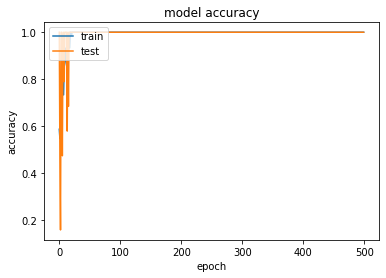

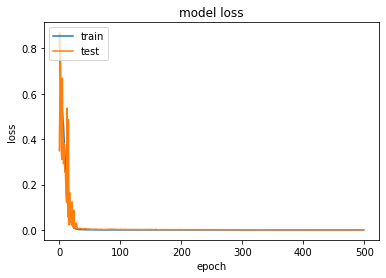

In [ ]:
# list all data in history
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# testing 3: CNN

In [ ]:
trainData,labelData = viewAllDataFromFolder("CBT/data","CBT/label",121)
trainData = np.delete(trainData, [1,2,3,6,9,10,11], 1) # cpu_system,pod_count,system_load,mem_avail,disk_io
trainData.shape
trainData = trainData.reshape(trainData.shape[0],trainData.shape[1],trainData.shape[2],1)

Num of file: 20
Label: {0: 46, 1: 48}
Shape lsBdTrain: (94, 12, 121)  lsBdLabel: (94, 1)


In [ ]:
#https://machinelearningmastery.com/how-to-develop-rnn-models-for-human-activity-recognition-time-series-classification/
model = keras.Sequential()
model.add(keras.layers.TimeDistributed(keras.layers.Conv1D(filters=4, kernel_size=3, activation='relu'), input_shape=(trainData.shape[1], trainData.shape[2], 1)))
model.add(keras.layers.TimeDistributed(keras.layers.Conv1D(filters=4, kernel_size=3, activation='relu')))
model.add(keras.layers.TimeDistributed(keras.layers.Dropout(0.5)))
model.add(keras.layers.TimeDistributed(keras.layers.MaxPooling1D(pool_size=2)))
model.add(keras.layers.TimeDistributed(keras.layers.Flatten()))
model.add(keras.layers.LSTM(50))
model.add(keras.layers.Dropout(0.5))
model.add(keras.layers.Dense(30, activation='relu'))
model.add(keras.layers.Dense(labelData.shape[1], activation='sigmoid' ))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed (TimeDistri (None, 5, 119, 4)         16        
_________________________________________________________________
time_distributed_1 (TimeDist (None, 5, 117, 4)         52        
_________________________________________________________________
time_distributed_2 (TimeDist (None, 5, 117, 4)         0         
_________________________________________________________________
time_distributed_3 (TimeDist (None, 5, 58, 4)          0         
_________________________________________________________________
time_distributed_4 (TimeDist (None, 5, 232)            0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 50)                56600     
_________________________________________________________________
dropout_1 (Dropout)          (None, 50)               

In [ ]:
history = model.fit(
    trainData, labelData,
    epochs=500,
    batch_size=32,
    validation_split=0.2,
    shuffle=True
)

Epoch 1/500
3/3 [==============================] - 3s 256ms/step - loss: 0.6920 - accuracy: 0.5200 - val_loss: 0.7933 - val_accuracy: 0.1579
Epoch 2/500
3/3 [==============================] - 0s 27ms/step - loss: 0.7023 - accuracy: 0.5200 - val_loss: 0.8749 - val_accuracy: 0.1579
Epoch 3/500
3/3 [==============================] - 0s 23ms/step - loss: 0.6811 - accuracy: 0.5867 - val_loss: 0.8950 - val_accuracy: 0.1579
Epoch 4/500
3/3 [==============================] - 0s 26ms/step - loss: 0.6733 - accuracy: 0.6133 - val_loss: 0.8961 - val_accuracy: 0.1579
Epoch 5/500
3/3 [==============================] - 0s 26ms/step - loss: 0.6677 - accuracy: 0.5600 - val_loss: 0.9083 - val_accuracy: 0.1579
Epoch 6/500
3/3 [==============================] - 0s 25ms/step - loss: 0.6655 - accuracy: 0.5733 - val_loss: 0.8812 - val_accuracy: 0.1579
Epoch 7/500
3/3 [==============================] - 0s 25ms/step - loss: 0.6728 - accuracy: 0.6000 - val_loss: 0.8428 - val_accuracy: 0.1579
Epoch 8/500
3/3 [==

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


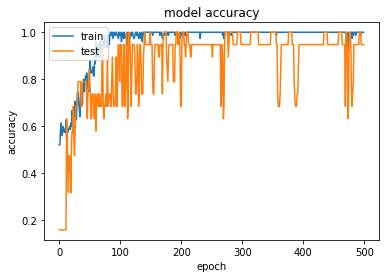

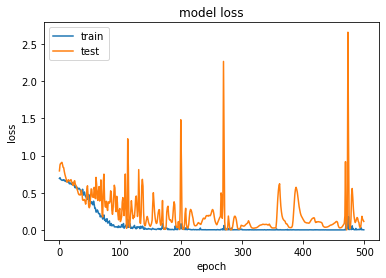

In [ ]:
# list all data in history
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()